In [84]:
import random

import cv2
import matplotlib.pyplot as plt
import ternausnet.models
from tqdm import tqdm
import torch
import torch.backends.cudnn as cudnn
import torch.optim
from torch.utils.data import Dataset, DataLoader

import albumentations as A
import albumentations.augmentations.transforms as T
from albumentations.pytorch import ToTensorV2

from segmentation_models_pytorch.losses import DiceLoss 
import glob
from matplotlib.colors import from_levels_and_colors
import numpy as np

from PIL import Image,ImageFilter
from skimage.morphology import skeletonize,square,dilation 

from PVBM.GeometricalAnalysis import GeometricalVBMs
from PVBM.FractalAnalysis import MultifractalVBMs

cudnn.benchmark = True

We can recompute the median tortuosity:2.0010837897337463 and we can compute the tortuosity index: 2.0010837897337463.


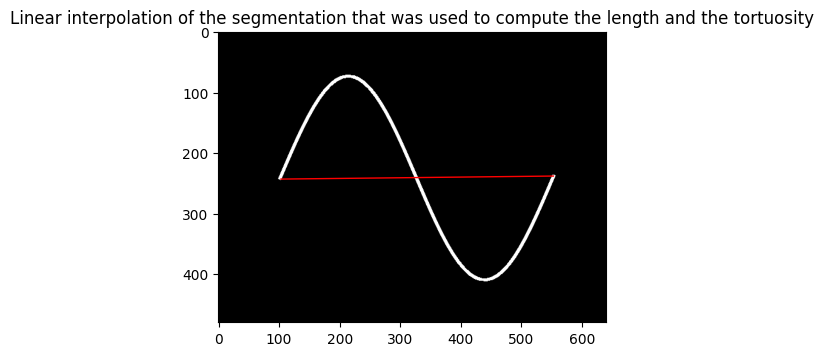

In [85]:
plt.plot(np.linspace(0,6.3), np.sin(np.linspace(0,6.3)), linewidth=4, c='black')
plt.axis('off')
plt.savefig('sinusoida.png')
plt.close()
sinusoida = plt.imread('sinusoida.png')
random_array = (sinusoida-1) * -255
random_array = random_array.astype(np.uint8)
segmentation = Image.fromarray(random_array)

segmentation = segmentation.convert('RGB')
segmentation = segmentation.filter(ImageFilter.ModeFilter(size=3))

segmentation = np.array(segmentation)/255 #Convert the segmentation to a numpy array with value 0 and 1
segmentation = segmentation[:,:,0]
skeleton = skeletonize(segmentation)
geometricalVBMs = GeometricalVBMs()
median_tor, length,chord,arc,connection_dico = geometricalVBMs.compute_tortuosity_length(skeleton)
print("We can recompute the median tortuosity:{} and we can compute the tortuosity index: {}."
      .format(np.median(np.array(arc)/np.array(chord)), np.sum(arc)/np.sum(chord)))
fig = plt.figure(figsize=(5,5))
for key,values in connection_dico.items():
    x1,y1 = key
    for value in values:
        x2,y2 = value[0][0],value[0][1]
        x_ = (x1,x2)
        y_ = (y1,y2)
        plt.plot(y_,x_, color="red", linewidth=1)
plt.imshow(segmentation,cmap = 'gray')
plt.title('Linear interpolation of the segmentation that was used to compute the length and the tortuosity')
plt.show()

In [86]:
model_name = "UNet11"
batch_size = 9
epochs_num = 35
img_size = 256
lr = 0.001
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = getattr(ternausnet.models, 'UNet11')(pretrained=True)
model = model.to(device)

criterion = DiceLoss(mode='binary').to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

class SegmDataset(Dataset):
    def __init__(self, images_paths, transform=None):
        self.images_paths = images_paths
        self.transform = transform

    def __len__(self):
        return len(self.images_paths)

    def __getitem__(self, idx):
        image_path = self.images_paths[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image=image[50:300,:250]

        original_size = tuple(image.shape[:2])        
        
        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed['image']
        return image, original_size

data_transforms = {
    'test': A.Compose([
        A.Resize(img_size,img_size),
        T.Normalize([0.3998, 0.1676, 0.0636], [0.2762, 0.1356, 0.0666]),
        ToTensorV2()
        ])
}

def predict(model):
    model.eval()
    predictions = []
    stream = tqdm(loaders['test'])
    with torch.no_grad():
        for i, (images, (original_heights, original_widths)) in enumerate(stream, start=1):
            images = images.to(device, non_blocking=True)
            output = model(images).squeeze(1)
            
            probabilities = torch.sigmoid(output.squeeze(1))
            predicted_masks = (probabilities >= 0.5).float() * 1
            probabilities = probabilities.cpu().numpy()
            predicted_masks = predicted_masks.cpu().numpy()
            for predicted_mask, probability, original_height, original_width in zip(
                predicted_masks, probabilities, original_heights.numpy(), original_widths.numpy()
            ):
                predictions.append((predicted_mask, probability, original_height, original_width))
    return predictions

100%|██████████| 1/1 [00:00<00:00,  1.79it/s]


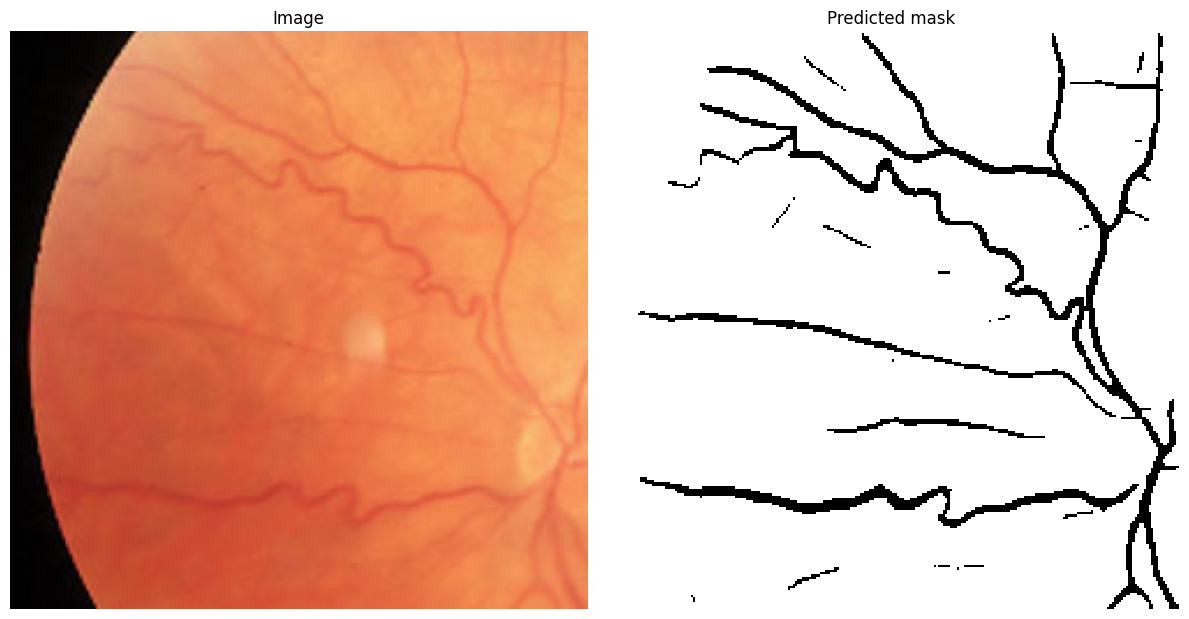

In [87]:
all_img_paths = glob.glob("data/test/img/*")+glob.glob("data/train/img/*")+glob.glob("data/val/img/*")
correct_images_paths = [i for i in all_img_paths if cv2.imread(i) is not None]

random.seed(33)
random.shuffle(correct_images_paths)

images_path = ['082_ro0117_f7-4.jpg']

datasets = {'test' : SegmDataset(images_path, transform=data_transforms['test'])}
loaders = {'test': DataLoader(datasets['test'], batch_size=1, shuffle=False, num_workers=0, pin_memory=True,)}

nm_model = '../unet/models/UNet11_e35_s256_b9_noaugm'
model.load_state_dict(torch.load(nm_model+'.pt'))
predictions = predict(model)
predicted_256x256_mask, _, original_height, original_width = predictions[0]
full_sized_mask = A.resize(
    predicted_256x256_mask, height=original_height, width=original_width, interpolation=cv2.INTER_NEAREST
)
    
figure, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 10))
image = cv2.imread(str(images_path[0]))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image=image[50:300,:250]

    
ax[0].imshow(image)
ax[0].set_title("Image")
ax[0].set_axis_off()
predicted_mask = full_sized_mask
ax[1].imshow(predicted_mask, interpolation="nearest", cmap='Greys')
ax[1].set_title("Predicted mask")
ax[1].set_axis_off()
plt.tight_layout()
plt.show()

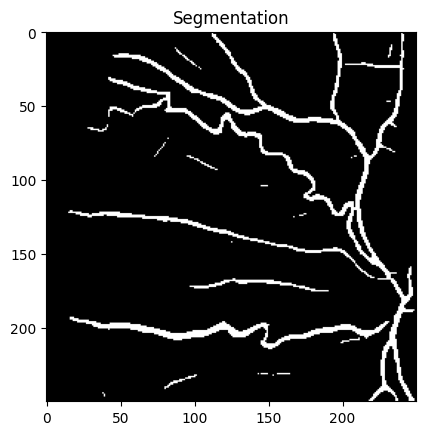

In [88]:
segmentation = Image.fromarray(predicted_mask*255)
plt.imshow(segmentation,cmap = "gray")
plt.title("Segmentation")
plt.show()

In [89]:
# Depending on the quality of the segmentation, you would need to regularize (smooth) it more or less 
#before computing the skeleton for instance by uncomment the following command
segmentation = segmentation.convert('RGB')
segmentation = segmentation.filter(ImageFilter.ModeFilter(size=3))

segmentation = np.array(segmentation)/255 #Convert the segmentation to a numpy array with value 0 and 1
segmentation = segmentation[:,:,0]
skeleton = skeletonize(segmentation) # Compute the skeleton of the segmentation


We can recompute the median tortuosity:1.0815389650284586 and we can compute the tortuosity index: 1.123060672221006.


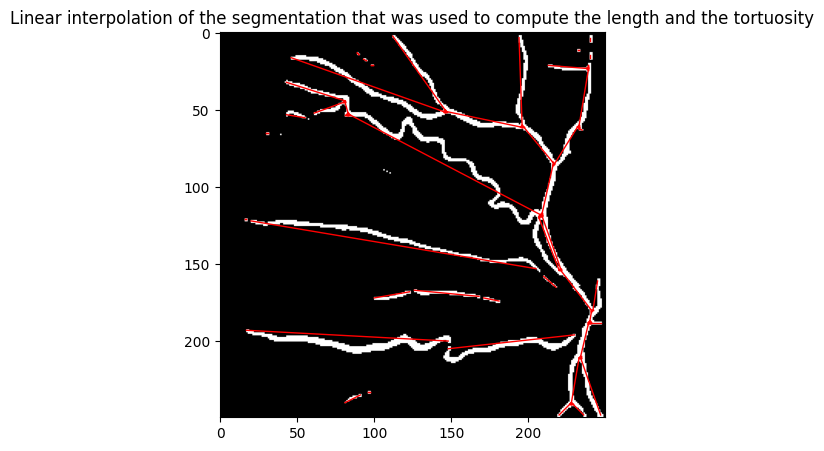

In [90]:
geometricalVBMs = GeometricalVBMs()
median_tor, length,chord,arc,connection_dico = geometricalVBMs.compute_tortuosity_length(skeleton)
print("We can recompute the median tortuosity:{} and we can compute the tortuosity index: {}."
      .format(np.median(np.array(arc)/np.array(chord)), np.sum(arc)/np.sum(chord)))
fig = plt.figure(figsize=(5,5))
for key,values in connection_dico.items():
    x1,y1 = key
    for value in values:
        x2,y2 = value[0][0],value[0][1]
        x_ = (x1,x2)
        y_ = (y1,y2)
        plt.plot(y_,x_, color="red", linewidth=1)
plt.imshow(segmentation,cmap = 'gray')
plt.title('Linear interpolation of the segmentation that was used to compute the length and the tortuosity')
plt.show()

In [91]:
segmentation_path = "data/data_m_vessel/test/retina/09_dr.tif"
segmentation = plt.imread(segmentation_path)[450:,1000:2500]

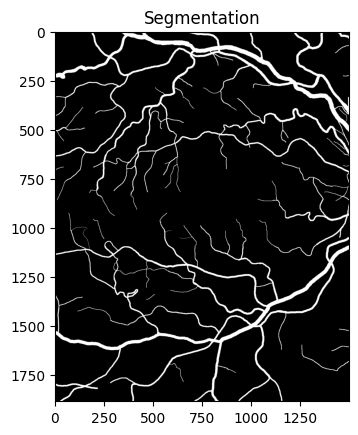

In [92]:
segmentation_path = "data/data_m_vessel/test/retina/09_dr.tif"
segmentation = plt.imread(segmentation_path)[450:,1000:2500]
segmentation = Image.fromarray(segmentation*255)
plt.imshow(segmentation,cmap = "gray")
plt.title("Segmentation")
plt.show()

We can recompute the median tortuosity:1.1077022349743726 and we can compute the tortuosity index: 1.1719434717739.


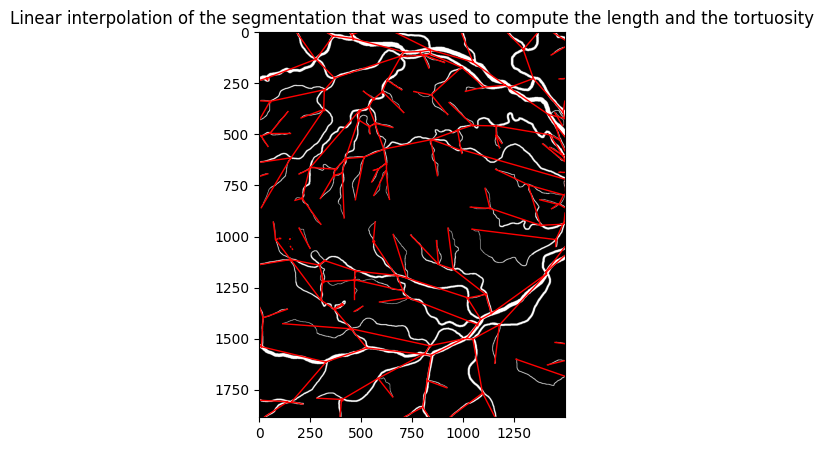

In [93]:
segmentation = segmentation.convert('RGB')
segmentation = segmentation.filter(ImageFilter.ModeFilter(size=3))

segmentation = np.array(segmentation)/255 #Convert the segmentation to a numpy array with value 0 and 1
segmentation = segmentation[:,:,0]
skeleton = skeletonize(segmentation)
geometricalVBMs = GeometricalVBMs()
median_tor, length,chord,arc,connection_dico = geometricalVBMs.compute_tortuosity_length(skeleton)
print("We can recompute the median tortuosity:{} and we can compute the tortuosity index: {}."
      .format(np.median(np.array(arc)/np.array(chord)), np.sum(arc)/np.sum(chord)))
fig = plt.figure(figsize=(5,5))
for key,values in connection_dico.items():
    x1,y1 = key
    for value in values:
        x2,y2 = value[0][0],value[0][1]
        x_ = (x1,x2)
        y_ = (y1,y2)
        plt.plot(y_,x_, color="red", linewidth=1)
plt.imshow(segmentation,cmap = 'gray')
plt.title('Linear interpolation of the segmentation that was used to compute the length and the tortuosity')
plt.show()

In [94]:
import matplotlib.pyplot as plt
import pandas as pd

data_a = pd.read_csv('morphological_data/morph_stats_aria.csv', index_col=0)
data_h = pd.read_csv('morphological_data/morph_stats_hrf.csv', index_col=0)
data_f = pd.read_csv('morphological_data/morph_stats_fives.csv', index_col=0)
data = pd.concat([data_a, data_h, data_f], axis=0, ignore_index=True)
data = data.drop('prob_0', axis=1)
data = data.drop('prob_1', axis=1)
data = data.drop('pred_status', axis=1)
col_names = data.columns.values.tolist()[1:]
col_names.append(data.columns.values.tolist()[0])
data = data[col_names]
data = data.reindex(columns=col_names)
data['diameter'] = data['area'] / data['length']
print(data.columns)
data.head()

Index(['group', 'status', 'area', 'endpoints', 'intersection_points',
       'median_tortuosity', 'tortuosity_index', 'length', 'perimeter',
       'BA_mean', 'BA_std', 'BA_median', 'D0', 'D1', 'D2', 'SL', 'image_name',
       'diameter'],
      dtype='object')


,group,status,area,endpoints,intersection_points,median_tortuosity,tortuosity_index,length,perimeter,BA_mean,BA_std,BA_median,D0,D1,D2,SL,image_name,diameter
0,test,0.0,8.689461,139.0,229.0,1.078279,1.099219,106.632566,234.974760,100.459093,49.387186,99.011606,1.517994,1.498753,1.489280,0.853023,aria_c_2_2_BDP.tif,0.081490
1,test,0.0,9.115413,319.0,321.0,1.078517,1.107091,115.472692,263.997329,81.449024,58.081470,82.228490,1.557956,1.540376,1.521362,0.452518,aria_c_2_8_BDP.tif,0.078940
2,test,0.0,8.304154,142.0,242.0,1.076243,1.083650,109.770908,239.680239,105.897363,50.668990,97.696052,1.515191,1.506909,1.497353,0.562682,aria_c_36_44_BDP.tif,0.075650
3,test,0.0,10.072177,217.0,299.0,1.075317,1.081964,128.303866,282.075113,88.756358,58.389418,82.614248,1.569262,1.563687,1.548196,0.474867,aria_c_38_42_BDP.tif,0.078503
4,test,0.0,7.540314,315.0,229.0,1.077154,1.087469,106.471108,242.227318,99.128903,52.245831,106.523867,1.541980,1.518671,1.496303,0.492801,aria_c_44_12_BDP.tif,0.070820


C:\Users\micha\AppData\Local\Temp\ipykernel_26952\1143252580.py:23: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for legobj in leg.legendHandles:


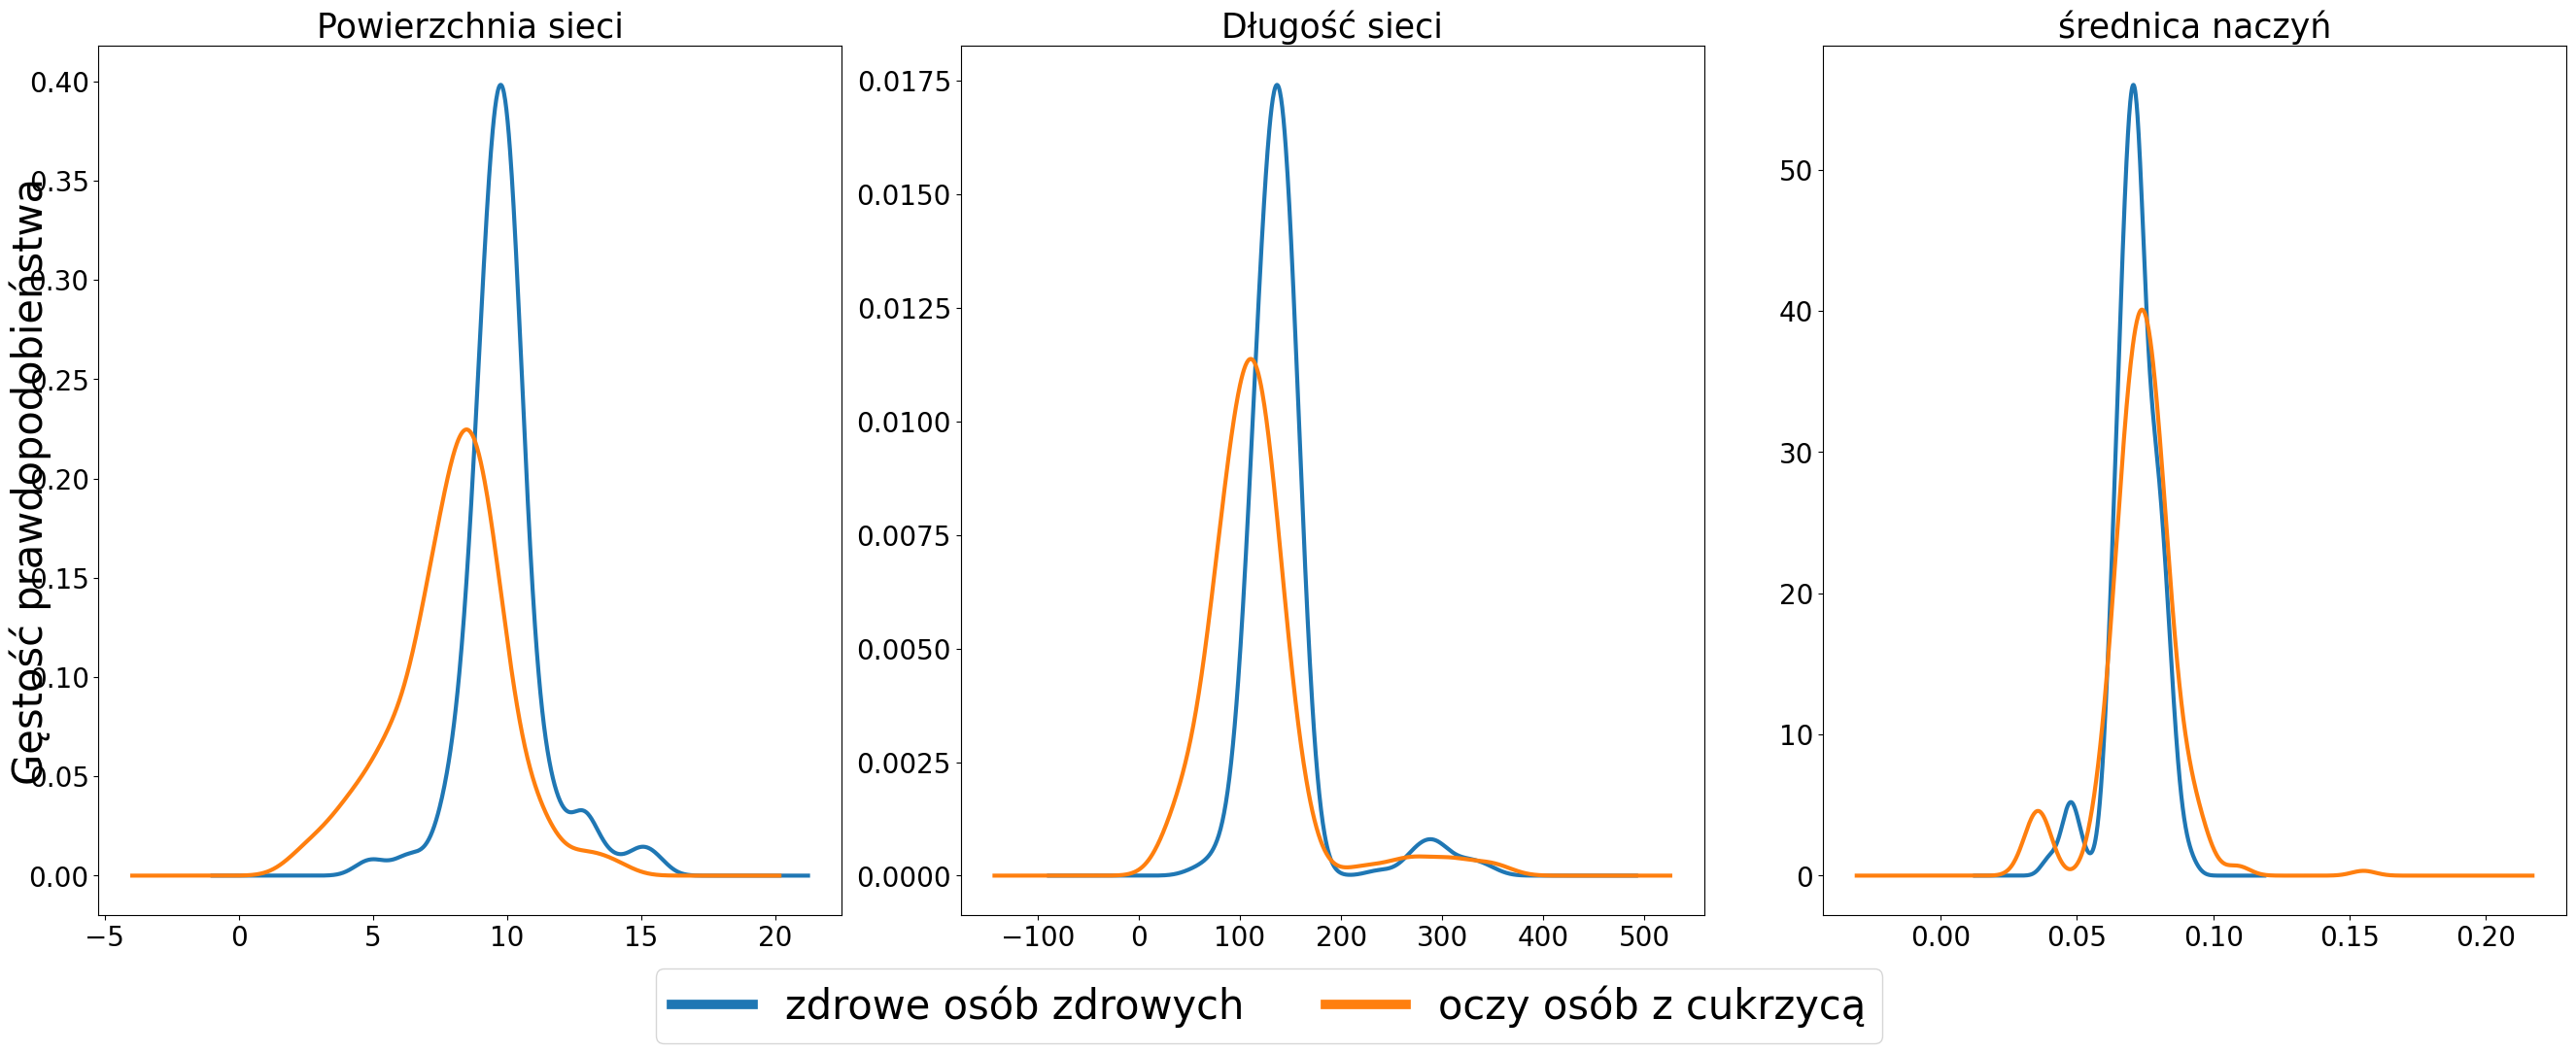

In [96]:
# data = data1.loc[data1['image_name'].str.contains('tif')]
fig, ax = plt.subplots(1, 3, figsize=(27,10))
data.loc[data['status'] == 0, 'area'].plot.kde(ax=ax[0], linewidth=3)
data.loc[data['status'] == 1, 'area'].plot.kde(ax=ax[0], linewidth=3)
ax[0].yaxis.label.set_visible(False)
ax[0].set_title('Powierzchnia sieci', fontsize=25)
ax[0].tick_params(labelsize=20)

data.loc[data['status'] == 0, 'length'].plot.kde(ax=ax[1], linewidth=3)
data.loc[data['status'] == 1, 'length'].plot.kde(ax=ax[1], linewidth=3)
ax[1].yaxis.label.set_visible(False)
ax[1].set_title('Długość sieci', fontsize=25)
ax[1].tick_params(labelsize=20)

data.loc[data['status'] == 0, 'diameter'].plot.kde(ax=ax[2], linewidth=3)
data.loc[data['status'] == 1, 'diameter'].plot.kde(ax=ax[2], linewidth=3)
ax[2].yaxis.label.set_visible(False)
ax[2].set_title('średnica naczyń', fontsize=25)
ax[2].tick_params(labelsize=20)

fig.supylabel('Gęstość prawdopodobieństwa', fontsize=30)
leg = fig.legend(['zdrowe osób zdrowych', 'oczy osób z cukrzycą'], loc='lower center', ncol=2, fontsize=30, bbox_to_anchor=(0.5, -0.1))
for legobj in leg.legendHandles:
    legobj.set_linewidth(7)
plt.tight_layout()

In [102]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

data0 = pd.read_csv('morphological_data/morph_data_ba_t.csv', index_col=0)
col_names = data0.columns.values.tolist()[1:]
col_names.append(data0.columns.values.tolist()[0])
data0 = data0[col_names]
data0 = data0.reindex(columns=col_names)
print(data0.columns)
data0.head()

data_a = pd.read_csv('morphological_data/morph_stats_aria.csv', index_col=0)
data_h = pd.read_csv('morphological_data/morph_stats_hrf.csv', index_col=0)
data_f = pd.read_csv('morphological_data/morph_stats_fives.csv', index_col=0)
data = pd.concat([data_a, data_h, data_f], axis=0, ignore_index=True)
data = data.drop('prob_0', axis=1)
data = data.drop('prob_1', axis=1)
data = data.drop('pred_status', axis=1)
col_names = data.columns.values.tolist()[1:]
col_names.append(data.columns.values.tolist()[0])
data = data[col_names]
data = data.reindex(columns=col_names)

data['diameter'] = data['area'] / data['length']

print(data.columns)
data.head()

Index(['group', 'status', 'median_tortuosity', 'tortuosities',
       'tortuosity_index', 'angles', 'BA_mean', 'BA_std', 'BA_median',
       'image_name'],
      dtype='object')
Index(['group', 'status', 'area', 'endpoints', 'intersection_points',
       'median_tortuosity', 'tortuosity_index', 'length', 'perimeter',
       'BA_mean', 'BA_std', 'BA_median', 'D0', 'D1', 'D2', 'SL', 'image_name',
       'diameter'],
      dtype='object')


,group,status,area,endpoints,intersection_points,median_tortuosity,tortuosity_index,length,perimeter,BA_mean,BA_std,BA_median,D0,D1,D2,SL,image_name,diameter
0,test,0.0,8.689461,139.0,229.0,1.078279,1.099219,106.632566,234.974760,100.459093,49.387186,99.011606,1.517994,1.498753,1.489280,0.853023,aria_c_2_2_BDP.tif,0.081490
1,test,0.0,9.115413,319.0,321.0,1.078517,1.107091,115.472692,263.997329,81.449024,58.081470,82.228490,1.557956,1.540376,1.521362,0.452518,aria_c_2_8_BDP.tif,0.078940
2,test,0.0,8.304154,142.0,242.0,1.076243,1.083650,109.770908,239.680239,105.897363,50.668990,97.696052,1.515191,1.506909,1.497353,0.562682,aria_c_36_44_BDP.tif,0.075650
3,test,0.0,10.072177,217.0,299.0,1.075317,1.081964,128.303866,282.075113,88.756358,58.389418,82.614248,1.569262,1.563687,1.548196,0.474867,aria_c_38_42_BDP.tif,0.078503
4,test,0.0,7.540314,315.0,229.0,1.077154,1.087469,106.471108,242.227318,99.128903,52.245831,106.523867,1.541980,1.518671,1.496303,0.492801,aria_c_44_12_BDP.tif,0.070820


In [103]:
tor0 = []
tor1 = []
for  ind, i in enumerate(data0.tortuosities.values):
    for x in (i)[1:-1].split(', '):
        if data0.status.values[ind] == 0:
            tor0.append(float(x))
        else:
            tor1.append(float(x))

ba0 = []
ba1 = []
for  ind, i in enumerate(data0.angles.values):
    for x in (i)[1:-1].split(', '):
        if data0.status.values[ind] == 0:
            ba0.append(float(x))
        else:
            ba1.append(float(x))

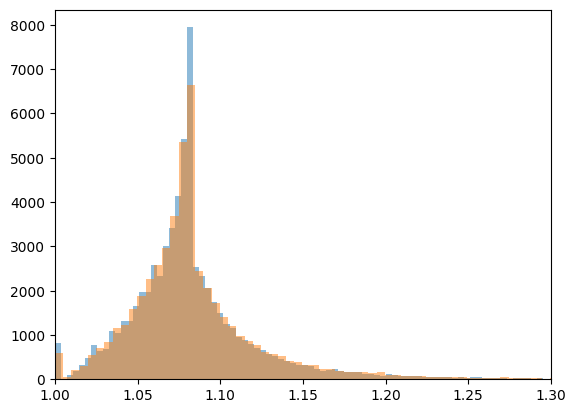

(array([ 480., 1473.,  837., 1055.,  650.,  687.,  763.,  633.,  612.,
         619.,  640.,  524.,  540.,  577.,  531.,  458.,  551.,  476.,
         511.,  543.,  534.,  551.,  521.,  568.,  458.,  685.,  586.,
         613.,  660.,  637.,  728.,  718.,  758.,  876.,  820., 1058.,
        1019., 1028., 1193., 1163., 1226., 1361., 1267., 1469., 1385.,
        1616., 1775., 1268., 1797., 1216., 1821., 1775., 1281., 1512.,
        1417., 1292., 1340., 1177., 1242., 1074., 1083., 1067., 1054.,
         993., 1058.,  929.,  992., 1055.,  973., 1021., 1046.,  990.,
         926., 1028.,  867., 1000., 1029.,  927.,  971.,  940.,  979.,
         918.,  978.,  943., 1036., 1092.,  921.,  935.,  927.,  967.,
        1017.,  965.,  924., 1026.,  962.,  939., 1145.,  906., 1064.,
         956.]),
 array([  0. ,   1.8,   3.6,   5.4,   7.2,   9. ,  10.8,  12.6,  14.4,
         16.2,  18. ,  19.8,  21.6,  23.4,  25.2,  27. ,  28.8,  30.6,
         32.4,  34.2,  36. ,  37.8,  39.6,  41.4,  43.2,  45

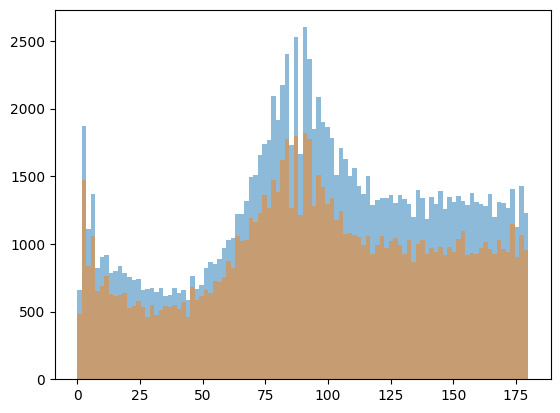

In [104]:
plt.hist(sorted(tor0, reverse=True)[20:], bins=400, alpha=0.5)
plt.hist(sorted(tor1, reverse=True)[20:], bins=400, alpha=0.5)
plt.xlim(1,1.15)
plt.show()
plt.hist(sorted(ba0, reverse=1), bins=100, alpha=0.5)
plt.hist(sorted(ba1, reverse=1), bins=100, alpha=0.5)

C:\Users\micha\AppData\Local\Temp\ipykernel_4336\3880440527.py:33: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for legobj in leg.legendHandles:


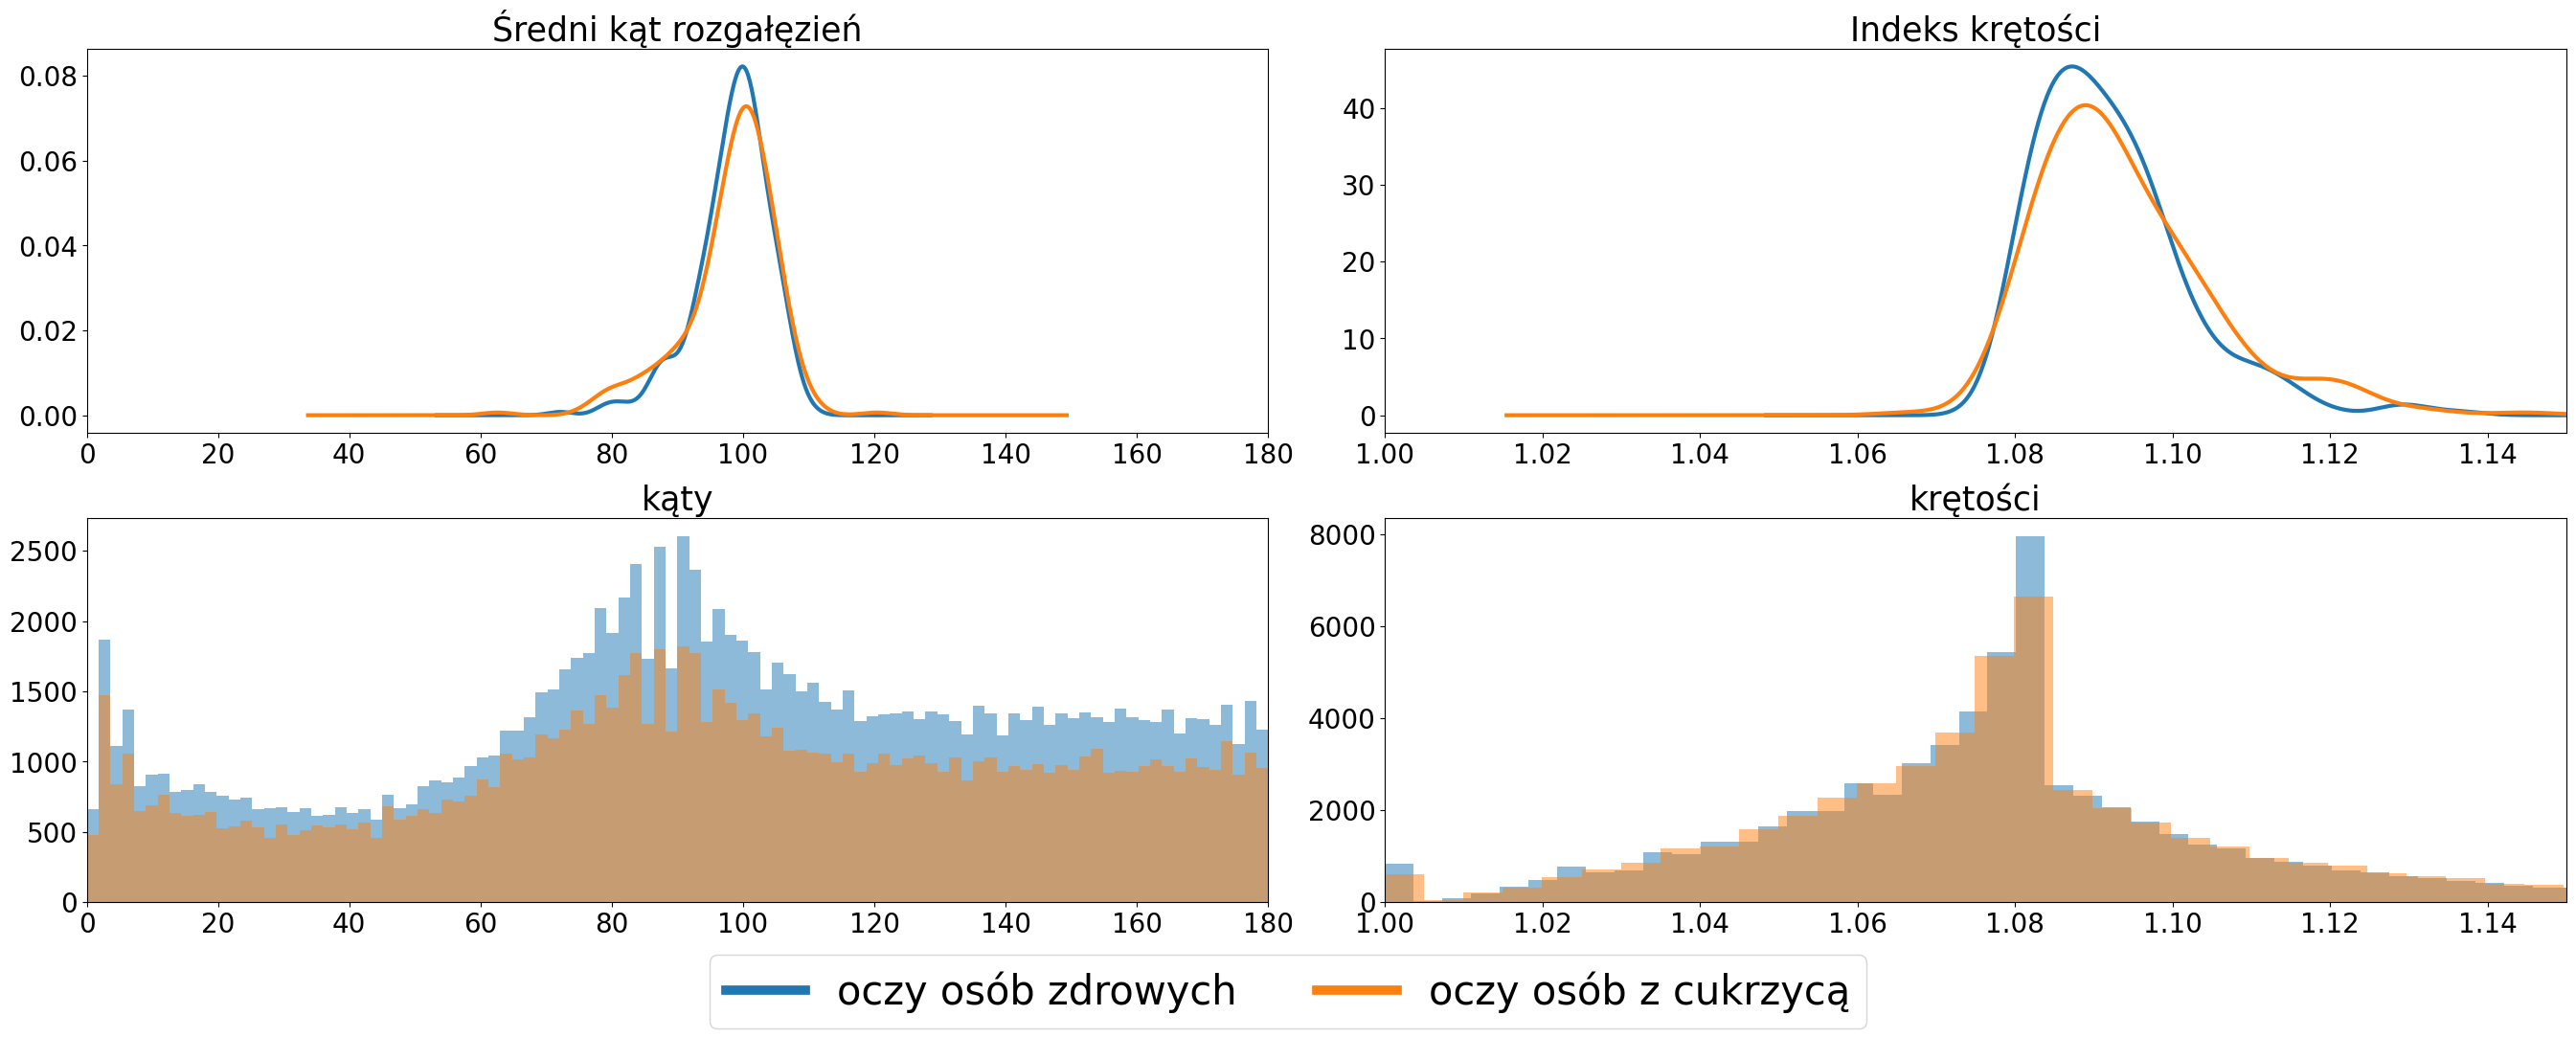

In [112]:
# data = data1.loc[data1['image_name'].str.contains('tif')]
fig, ax = plt.subplots(2, 2, figsize=(27,10))

data.loc[data['status'] == 0, 'BA_mean'].plot.kde(ax=ax[0,0], linewidth=3)
data.loc[data['status'] == 1, 'BA_mean'].plot.kde(ax=ax[0,0], linewidth=3)
ax[0,0].yaxis.label.set_visible(False)
ax[0,0].set_title('Średni kąt rozgałęzień', fontsize=25)
ax[0,0].tick_params(labelsize=20)
ax[0,0].set_xlim([0, 180])

data.loc[data['status'] == 0, 'tortuosity_index'].plot.kde(ax=ax[0,1], linewidth=3)
data.loc[data['status'] == 1, 'tortuosity_index'].plot.kde(ax=ax[0,1], linewidth=3)
ax[0,1].yaxis.label.set_visible(False)
ax[0,1].set_title('Indeks krętości', fontsize=25)
ax[0,1].tick_params(labelsize=20)
ax[0,1].set_xlim([1.0, 1.15])

ax[1,1].hist(sorted(tor0, reverse=True)[20:], bins=400, alpha=0.5)
ax[1,1].hist(sorted(tor1, reverse=True)[20:], bins=400, alpha=0.5)
ax[1,1].yaxis.label.set_visible(False)
ax[1,1].set_title('krętości', fontsize=25)
ax[1,1].tick_params(labelsize=20)
ax[1,1].set_xlim([1.0, 1.15])

ax[1,0].hist(sorted(ba0, reverse=1), bins=100, alpha=0.5)
ax[1,0].hist(sorted(ba1, reverse=1), bins=100, alpha=0.5)
ax[1,0].yaxis.label.set_visible(False)
ax[1,0].set_title('kąty', fontsize=25)
ax[1,0].tick_params(labelsize=20)
ax[1,0].set_xlim([0, 180])

leg = fig.legend(['oczy osób zdrowych', 'oczy osób z cukrzycą'], loc='lower center', ncol=2, fontsize=30, bbox_to_anchor=(0.5, -0.1))
for legobj in leg.legendHandles:
    legobj.set_linewidth(7)
plt.tight_layout()